<a href="https://colab.research.google.com/github/nyp-sit/iti121-2025s2/blob/main/L6/yolo_custom_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using YOLO

Welcome to this week's hands-on lab. In this lab, we are going to learn how to train a gold fish detector!

At the end of this exercise, you will be able to:

- create an object detection dataset in YOLO format
- fine-tune a YOLO pretrained model with the custom dataset
- monitor the training progress and evaluation metrics
- deploy the trained model for object detection

## Create an object detection dataset

We will use a goldfish dataset to illustrate the process of annotation and packaging the dataset into different format for object detection (e.g. YOLO, Pascal VOC, COCO, etc).

To annotate, there are many different tools available, such as the very basic [LabelImg](https://github.com/HumanSignal/labelImg) , or the more feature-packed tool such as [Label Studio](https://labelstud.io/), or online service such as [Roboflow](https://roboflow.com/).

### Raw Image Dataset

You can download the goldfish images (without annotations) from this link:

https://github.com/nyp-sit/iti121-2025s2/raw/refs/heads/main/L6/data/goldfish_v1_raw.zip


Unzip the file to a local folder.

There are total of 74 images. You should divide the images into both training and validation set (e.g. 80%-20%, i.e. 59 images for train, and 15 for test).


### Option 1: Label Studio

You can follow the [steps](https://labelstud.io/guide/quick_start) here to setup Label Studio on your PC. It is recommended to setup a conda environment before you install the Label Studio.  

Here are the steps that need to be done:
1. Create a new Project
2. Import the images into Label Studio
3. Set up the Labelling UI tempalte (choose Object Detection with Bounding Box template)
4. Export the dataset in YOLO format.

The exported dataset will have the following folder structure:
```
<root folder>
classes.txt    --> contains the labels, with each class label on a new line
--images --> contains the images
--labels --> contains the annotations (i.e. bbox coordinates)
notes.json --> some info about this dataset (i.e. not used)
```

For training with YOLOv11 (from Ultralytics), you need to organize the files into `train` and `validate` (and optionally `test`) folders, and to create a `data.yaml` file to provide information about the folder location of test and validation set:

```
<root folder>
--train
----images
----labels
--valid
----images
----labels
data.yaml
```

The data.yaml file should specify the following:
```
train: ../train/images
val: ../valid/images
test: ../test/images

names:
    0: goldfish
```

If you have more than one class of object to detect, specify the rest of the names under the names field.


## Option 2: Roboflow

Alternatively, you can use the online service Roboflow to do annotation. Roboflow integrates very well with Ultralytics and you can easily export the dataset in a format recognized by Ultralytics trainer (for YOLO model)

You can create a new account with [Roboflow](https://roboflow.com/).

After logging in, you can create a new project, upload all the raw images, annotate them and then export.

You can choose the format to be YOLOv11 and choose local directory to download the dataset locally instead of pushing it to the Roboflow universal wish.

Here is a [introductory blog](https://blog.roboflow.com/getting-started-with-roboflow/) on using the Roboflow to annotate.





## Auto Labelling using Grounding DINO

Both Label Studio and Roboflow supports the use of Grounding DINO to auto label the dataset.

[Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is open-set object detector, marrying Transformer-based detector DINO with grounded pre-training, which can detect arbitrary objects with human inputs (prompts) such as category names or referring expressions.

### Using Grounding DINO with Label Studio

You can follow the instruction [here](https://labelstud.io/blog/using-text-prompts-for-image-annotation-with-grounding-dino-and-label-studio/)  to setup the Grounding DINO ML backend to integrate with your label studio.

### Using Grounding DINO with Roboflow

Here is a [video tutorial](https://youtu.be/SDV6Gz0suAk) on using Grounding DINO with Roboflow.


### Download Annotated Dataset

To save you time for this lab, you can download a pre-annotated goldfish_v1 dataset [here](https://github.com/nyp-sit/iti121-2025s2/raw/refs/heads/main/L6/data/goldfish_v1.zip).

We download and unzip to the directory called `datasets/goldfish_v1`



In [ ]:
%%capture
%%bash

wget https://github.com/nyp-sit/iti121-2025s2/raw/refs/heads/main/L6/data/goldfish_v1.zip
mkdir -p datasets/goldfish_v1/
unzip goldfish_v1.zip -d datasets/

In [ ]:
%%capture
!pip install ultralytics

## Training the Model

YOLOv11 comes with different sizes of pretrained models: yolo11n, yolo11s, .... They differs in terms of their sizes, inference speeds and mean average precision:

<img src="https://github.com/nyp-sit/iti121-2025s2/blob/main/L6/assets/yolo11-models.png?raw=true" width="70%"/>


We will use the small pretrained model yolo11s and finetune it on our custom dataset.


### Setup the logging

Ultralytics support logging to `wandb`, `comet.ml` and `tensorboard` and `mlflow` out of the box. Here we only enable wandb.

You need to create an account at [`wandb`](https://wandb.ai) and get the API key from https://wandb.ai/authorize.

*For mlflow users, you can refer to Ultralytics's mlflow integration here: https://docs.ultralytics.com/integrations/mlflow/*


In [1]:
import wandb

# Replace 'YOUR_LONG_API_KEY_HERE' with the actual key you copied
wandb.login(key="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")

from ultralytics import settings

settings.update({"wandb": True,
                 "clearml": False,
                 "comet": False})

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kings\_netrc
wandb: Currently logged in as: kingstrife (kingstrife-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Training

We specify the path to `data.yaml` file, and train with a batch size of 64 (reduce accordingly if you encounter out-of-memory error), and we also save the checkpoint at each epoch (save_period=1). We assume here you are connected to a GPU, hence we can specify the device to use as `device=0` to select the first GPU.  We specify the project name as `goldfish_v1`, this will create a folder called `goldfish_v1` to store the weights and various training artifacts such as F1, PR curves, confusion matrics, training results (loss, mAP, etc).

For a complete listing of train settings, you can see [here](https://docs.ultralytics.com/modes/train/#train-settings).

You can also specify the type of data [augmentation](https://docs.ultralytics.com/modes/train/#augmentation-settings-and-hyperparameters)  you want as part of the train pipeline.

You can monitor your training progress at wandb (the link is given in the train output below)


In [ ]:
!ls -la datasets/goldfish_v1/train/images | wc -l

In [2]:
from ultralytics import YOLO
from ultralytics import settings

model = YOLO("yolo11s.pt")  # Load a pre-trained YOLO model
result = model.train(data="datasets/safari_project/data.yaml",
                     epochs=30,
                  #   save_period=1,
                     batch=8,
                     device=0,
                     project='safari_project_2nd_Iteration',
                     plots=True,
                     workers=1)

Ultralytics 8.3.252  Python-3.12.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets/safari_project/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

wandb: WARNING Tried to log to step 30 that is less than the current step 31. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.


lr/pg0,▁▂▃▄▅▅▆▆▇▇████▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▁▂▃▄▅▅▆▆▇▇████▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▁▂▃▄▅▅▆▆▇▇████▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/mAP50(B),▄▆▂▁▁▂▅▄▃▅▄▃▃▄▆▅▅▅▅▅▇▇▇█████▇█
metrics/mAP50-95(B),▅▆▂▁▁▁▄▃▂▄▃▃▃▃▅▄▃▃▅▄▆▆▇▇▇▇█▇▇█
metrics/precision(B),▄▅▂▁▁▁▃▃▃▃▃▄▃▄▅▄▃▂▅▄▇▇▆▆▇█▇▆▆▇
metrics/recall(B),▄▆▁▃▁▂▄▂▂▆▆▃▂▄▇▆▆▅▆▇▇▆▇▇█████▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
+6,...


You can see the various graphs in your wandb dashboard, for example:

*metrics*

<img src="https://github.com/nyp-sit/iti121-2025s2/blob/main/L6/assets/wandb-metrics.png?raw=true" width="70%"/>

*Train and validation loss*

<img src="https://github.com/nyp-sit/iti121-2025s2/blob/main/L6/assets/wandb-loss.png?raw=true" width="70%"/>

You can go to the folder `goldfish_v1-->train-->weights` and you will files like epoch0.pt, epoch1.pt, .... and also best.pt.
The epoch0.pt, epoch1.pt are the checkpoints that are saved every period (in our case, we specify period as 1 epoch).  The best.pt contains the best checkpoint.

We can run the best model (using the best checkpoint) against the validation dataset to see the overall model performance on validation set.  

You should see around `0.95` for `mAP50`, and `0.45` for `mAP50-95`.

In [3]:
from ultralytics import YOLO

# 1. Load your specific Lion/Buffalo model
model = YOLO(r"safari_project_2nd_Iteration\train\weights\best.pt") 
# 2. Run Validation
# This generates the Confusion Matrix and PR Curves
validation_results = model.val(data="datasets/safari_project/data.yaml", device="0")

# 3. Print the results (Optional, for your own info)
print(f"Mean Average Precision (mAP50): {validation_results.box.map50}")
print(f"Confusion Matrix saved to: {validation_results.save_dir}")

Ultralytics 8.3.252  Python-3.12.5 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 SUPER, 12282MiB)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 398.0405.3 MB/s, size: 41.6 KB)
val: Scanning C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\datasets\safari_project\valid\labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 17/17  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.1it/s 1.9s5.9s
                   all         17         17       0.84      0.914      0.955      0.732
               buffalo          8          8      0.968          1      0.995      0.746
                  lion          9          9      0.712      0.828      0.916      0.718
Speed: 3.0ms preprocess, 24.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to C:\Users\king

In [5]:
from ultralytics import YOLO
import os

# 1. Load your Best Model (Using the path from your training logs)
model_path = r"safari_project_2nd_Iteration/train/weights/best.pt"
model = YOLO(model_path)

# 2. Define your Test Image
# Make sure this file exists in your current folder!
source_image = "Test_Run\\2buffalos.jpg" 

# 3. Run Inference
if os.path.exists(source_image):
    print(f"🔎 Testing model on: {source_image}...")
    
    # save=True  -> Saves the file (REQUIRED for your assignment)
    # show=True  -> Pops up a window to let you see it immediately
    # conf=0.5   -> Only shows boxes if the model is 50% sure
    results = model.predict(source=source_image, save=True, show=True, conf=0.5)

    # 4. Print the Output Location
    # You need this folder to retrieve the image for your report
    print(f"\n✅ SUCCESS! Predicted image saved to: {results[0].save_dir}")
    print("👉 Go to that folder to find the image with boxes drawn on it.")
else:
    print(f"❌ Error: Could not find '{source_image}'. Please check the filename.")

🔎 Testing model on: Test_Run\2buffalos.jpg...

image 1/1 C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\Test_Run\2buffalos.jpg: 480x640 2 buffalos, 37.4ms
Speed: 1.7ms preprocess, 37.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\runs\detect\predict8

✅ SUCCESS! Predicted image saved to: C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\runs\detect\predict8
👉 Go to that folder to find the image with boxes drawn on it.


## Export and Deployment

Your model is in pytorch format (.pt). You can export the model to various format, e.g. TorchScript, ONNX, OpenVINO, TensorRT, etc. depending on your use case, and deployment platform (e.g. CPU or GPU, etc)

You can see the list of [supported formats](https://docs.ultralytics.com/modes/export/#export-formats)  and the option they support in terms of further optimization (such as imagesize, int8, half-precision, etc) in the ultralytics site.

Ultralytics provide a utility function to benchmark your model using different supported formats automatically. You can uncomment the code in the following code cell to see the benchmark result. If you are benchmarking for CPU only, the change the `device=0` to `device='cpu'`.  

**Beware: it will take quite a while to complete the benchmark**

In [ ]:
from ultralytics.utils.benchmarks import benchmark

# Run the benchmark
# This will automatically export your model to different formats (ONNX, OpenVINO, etc.)
# and test the speed (FPS) of each one.
benchmark(
    model="safari_project_2nd_Iteration/train/weights/best.pt",  # <--- Point to your NEW model
    data="datasets/safari_project/data.yaml",                    # <--- Point to your Safari data
    imgsz=640, 
    half=False, 
    device=0
)


In the following code, we export it as OpenVINO. OpenVINO is optimized for inference on Intel CPUs and since we will use the model later on to do inference on local Windows machine (which runs Intel chip), we will export it as OpenVINO format. We also specify using int8 quantization, which results in faster inference, at the cost of accuracy.

For more information on OpenVINO, go to the [official documentation](https://docs.openvino.ai/2024/index.html).

After export, you can find the openvino model in `goldfish_v1\train\weights\best_openvino_model` directory.

In [6]:
from ultralytics import YOLO

# 1. Load your NEW Lion/Buffalo model
# (Using the path we confirmed in the previous step)
model = YOLO(r"safari_project_2nd_Iteration/train/weights/best.pt")

# 2. Export to OpenVINO with INT8 Quantization
# IMPORTANT: You MUST include 'data=' so the model can calibrate the INT8 compression!
exported_path = model.export(
    format="openvino", 
    int8=True, 
    data="datasets/safari_project/data.yaml"  # <--- Required for int8
)

Ultralytics 8.3.252  Python-3.12.5 torch-2.6.0+cu124 CPU (AMD Ryzen 7 7800X3D 8-Core Processor)
YOLO11s summary (fused): 100 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

PyTorch: starting from 'safari_project_2nd_Iteration\train\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (18.3 MB)

OpenVINO: starting export with openvino 2025.4.1-20426-82bbf0292c5-releases/2025/4...


C:\apps\Python\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


OpenVINO: collecting INT8 calibration images from 'data=datasets/safari_project/data.yaml'
Fast image access  (ping: 0.10.0 ms, read: 391.4252.5 MB/s, size: 38.0 KB)
Scanning C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\datasets\safari_project\valid\labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 17/17  0.0s
WARNING OpenVINO: >300 images recommended for INT8 calibration, found 17 images.
INFO:nncf:15 ignored nodes were found by patterns in the NNCFGraph
INFO:nncf:1 ignored nodes were found by types in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 168 __module.model.23.dfl/aten::view/Reshape
INFO:nncf:Not adding activation input quantizer for operation: 169 __module.model.23/aten::sigmoid/Sigmoid
INFO:nncf:Not adding activation input quantizer for operation: 180 __module.model.23.dfl/aten::transpose/Transpose
INFO:nncf:Not adding activation input quantizer for operation: 191 __modu

C:\apps\Python\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\apps\Python\Lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

OpenVINO: export success  17.5s, saved as 'safari_project_2nd_Iteration\train\weights\best_int8_openvino_model\' (9.8 MB)

Export complete (17.7s)
Results saved to C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\safari_project_2nd_Iteration\train\weights
Predict:         yolo predict task=detect model=safari_project_2nd_Iteration\train\weights\best_int8_openvino_model imgsz=640 int8 
Validate:        yolo val task=detect model=safari_project_2nd_Iteration\train\weights\best_int8_openvino_model imgsz=640 data=datasets/safari_project/data.yaml int8 
Visualize:       https://netron.app


## Inference

Let's test our model on some sample pictures. You can optionally specify the confidence threshold (e.g. `conf=0.5`), and the IoU (e.g. `iou=0.6`) for the NMS. The model will only output the bounding boxes of those detection that exceeds the confidence threshould and the IoU threshold.  

Loading OpenVINO model from: safari_project_2nd_Iteration/train/weights/best_int8_openvino_model
Loading safari_project_2nd_Iteration/train/weights/best_int8_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference on CPU...

image 1/1 C:\Users\kings\OneDrive\Education\NYP Gen AI Course\121 - Applied Deep Learning\Assignment 2\Data\Test_Run\2buffalos.jpg: 640x640 2 buffalos, 20.2ms
Speed: 1.8ms preprocess, 20.2ms inference, 6.6ms postprocess per image at shape (1, 3, 640, 640)


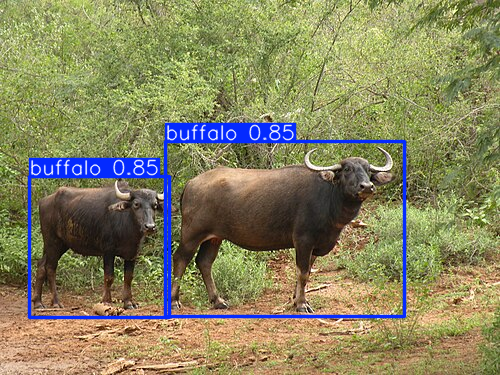

✅ Saved prediction to: openvino_prediction_0.jpg


In [9]:
import ultralytics
from ultralytics import YOLO
from PIL import Image
import cv2

# 1. Define your Source (Use your local lion image)
source = "Test_Run\\2buffalos.jpg"

# 2. Load the EXPORTED OpenVINO Model
# Note: Point to the FOLDER created by the export, not a specific file.
# It usually ends in '_int8_openvino_model'
model_path = r"safari_project_2nd_Iteration/train/weights/best_int8_openvino_model"
model = YOLO(model_path, task='detect')

# 3. Run Inference
# The OpenVINO engine is stricter. We explicitly set the task.
print(f"Loading OpenVINO model from: {model_path}")
results = model(source, conf=0.25, iou=0.45)

# 4. Visualize and Save
for i, r in enumerate(results):
    # Plot results (returns a numpy array in BGR)
    im_bgr = r.plot() 
    
    # Convert BGR (OpenCV format) to RGB (Pillow format)
    im_rgb = Image.fromarray(im_bgr[..., ::-1]) 
    
    # Display in Notebook (Better than .show() popup)
    display(im_rgb)

    # Save to disk
    save_filename = f"openvino_prediction_{i}.jpg"
    r.save(filename=save_filename)
    print(f"✅ Saved prediction to: {save_filename}")

## Download the Model

If you are training your model on Google Colab, you will download the exported OpenVINO model to a local PC. If you are training your model locally, then the exported model should already be on your local PC.

Run the following code to zip up the OpenVINO folder and download to local PC.

*Note: If you encountered error message "NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968", uncomment the following cell and run it.*


In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
%%bash
mv ./goldfish_v1/train/weights/best_int8_openvino_model/ .
zip -r goldfish_v1_openvino_model.zip best_int8_openvino_model

# Now go to best_openvino_model to download the best_openvino_model.zip file

## Streaming

We can also do real-time detection on a video or camera steram.

The code below uses openCV library to display video in a window, and can only be run locally on a local laptop.




### Video File

You need `OpenCV` to run the following code.  In your conda environment, install `opencv` for python using the following command:

```
pip3 install opencv-python
```
or
```
conda install opencv
```

Let's donwload the sample video file.

In [ ]:
!wget https://raw.githubusercontent.com/nyp-sit/iti121-2025S2/refs/heads/main/L6/samples/goldfish_480p_10s.mp4

### Streaming and display video

In [ ]:
from ultralytics import YOLO
import cv2
from tqdm.auto import tqdm
import os

# 1. SETUP PATHS
# Use your exported OpenVINO model path
model_path = "safari_project_2nd_Iteration/train/weights/best_int8_openvino_model"
video_in = "test_run\\lion_chase_buffalo.mp4"       # Your input video
video_out = "test_run\\project_final_result.mp4"    # Your final submission file

# 2. LOAD MODEL
print(f"Loading model from: {model_path}...")
model = YOLO(model_path, task='detect')

def write_video(video_in_filepath, video_out_filepath, model):
    # Open the video file
    video_reader = cv2.VideoCapture(video_in_filepath)

    # Check if video opened successfully
    if not video_reader.isOpened():
        print("Error: Could not open video.")
        return

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Setup Video Writer
    video_writer = cv2.VideoWriter(video_out_filepath,
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps,
                            (frame_w, frame_h))

    print(f"Processing {nb_frames} frames...")

    # Loop through the video frames
    for i in tqdm(range(nb_frames)):
        success, frame = video_reader.read()

        if success:
            # Run YOLO inference
            # REMOVED 'device=0' because OpenVINO handles device selection automatically
            results = model(frame, conf=0.5)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Write the annotated frame
            video_writer.write(annotated_frame)

    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()
    print(f"✅ Success! Saved to: {video_out_filepath}")

# 3. RUN IT
write_video(video_in, video_out, model)

### Detect and write to a video file

In [11]:
from ultralytics import YOLO
import cv2
# from tqdm import tqdm
from tqdm.auto import tqdm

def write_video(video_in_filepath, video_out_filepath, model):
    # Open the video file

    video_reader = cv2.VideoCapture(video_in_filepath)

    nb_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_h = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frame_w = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    video_writer = cv2.VideoWriter(video_out_filepath,
                            cv2.VideoWriter_fourcc(*'mp4v'),
                            fps,
                            (frame_w, frame_h))

    # Loop through the video frames
    for i in tqdm(range(nb_frames)):
        # Read a frame from the video
        success, frame = video_reader.read()

        if success:
            # Run YOLO inference on the frame on GPU Device 0
            results = model(frame, conf=0.6, device=0)

            # Visualize the results on the frame
            annotated_frame = results[0].plot()

            # Write the annotated frame
            video_writer.write(annotated_frame)

    video_reader.release()
    video_writer.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)


ModuleNotFoundError: No module named 'tqdm'

In [ ]:
from pathlib import Path
import os

video_in_file = "goldfish_480p_10s.mp4"
basename = Path(video_in_file).stem
video_out_file = os.path.join(basename + '_detected' + '.mp4')
model = YOLO("best_int8_openvino_model", task="detect")
write_video(video_in_file, video_out_file, model)

## Improving the object detection model

You will notice that the trained goldfish detector did not perform well in detecting the goldfishes in the fish tank.  

Can you give a reason why?

### Exercise

Now take a look at goldfish_v2 dataset.  What do you observe? Do you think this is a better dataset to use for the domain that was set.

Now train a goldfish detector, using the goldfish_v2 dataset.  Evaluate the model on the same sample image and video. Compare the results and discuss.